In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
#from celluloid import Camera
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 14})

def plot_convection(u_k,k):
    """
    Plots the 1D velocity field
    """
    plt.clf()
    plt.plot(x,u_k,'r')
    plt.xlabel('x (µm)')
    plt.ylabel('Density')
    plt.ylim([0,1])
    #plt.ylim([np.nanmin(u)-0.1*abs(np.amax(u)),1.1*np.amax(u)])
    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    return plt

def plot_convection2(u,k,i,x):
    plt.semilogy(x,u[:,k],color=colorwave[i])
    plt.xlabel('x (µm)')
    plt.ylabel('Density')
    #plt.ylim([np.amin(u)-0.1,np.amax(u)+0.1])
    #plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    
def animate(k):
    plot_convection(u[:,k], k)
    
def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,int(nx/2+1))
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

def normalize(inn):                                  #normalize the input curve to 1
    return inn/(sum(inn)*dx)

def calcvelocitysingle(rvalue,sigma,vdiff,A,vmin):   #Calculate the introduced velocity profile at a single position
    sigmaterm = sigma**2
    I = A*np.exp(-rvalue**2/sigmaterm)
    return vdiff*np.exp(-I/A)+vmin

## Initial parameters

In [2]:
name = 'Focker-Planck'

amplitude = 1                    #Amplitude, always 1
vmin = 0                         #Min velocity
vmax = 1                         #Max velocity
pxtomum=0.0533e-6               #px to µm [µm/px]
sigma = 50*pxtomum               #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14#*1e12              #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200   #Size of the arena
vactive = 6e-6                      #Active velocity

vdiff = vmax-vmin
nx = 401
nt = 50
tauR = 1
delta_x = 2*boundaryradius/nx

frames = 6
dt = 0.05
videosize = 800        #800, 521, 256, 128
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 10e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3

check = True
dtframetransfer = videosize/binning * verticalshift
dtreadout = (1032/27e6+verticalshift)*videosize/binning
dtexphalf = flashtime/2
dttest = flashtime + dtframetransfer + dtreadout
dtcycle = dt + dtframetransfer
dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin + (frames-1)*dtcycle
if dttest > dt: 
    check = False
    dtnew = dttest
    dtcycle = dttest    

if check == True: print('dt = ',round(dt*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
else: print('dt = ',round(dtnew*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
delta_t = dttotal/nt#(delta_x ** 2)/(4 * alpha)
totaltime = dttotal

dt =  50.0 ms - delay =  308.3 ms - cycle time =  51.5 ms


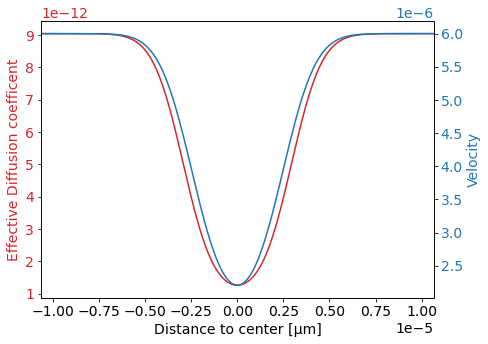

In [3]:
xarray1, varray1, Iarray1 = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
xarray = np.linspace(-boundaryradius,boundaryradius,nx)
varray = np.zeros(nx)
for i in range(int(nx/2+1)):
    varray[int(nx/2)+i] = varray1[i]
    varray[int(nx/2)-i] = varray1[i]
Darray = D_0 + varray**2*tauR/4

fig, ax = plt.subplots(figsize=(7,5)) 
ax1 = plt.subplot(1,1,1)
color1 = 'tab:red'
ax1.plot(xarray,Darray,color=color1)
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Effective Diffusion coefficent',color=color1) 
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim([-boundaryradius,boundaryradius])
#ax1.set_ylim([0,9.5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.plot(xarray,varray,color=color2)
ax2.set_ylabel('Velocity',color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#ax2.set_ylim([0,6.5])

plt.tight_layout() 
plt.savefig('Diffusion coefficent profiles.pdf', format='pdf')
plt.savefig('Diffusion coefficent profiles.svg', format='svg')
plt.show()

In [4]:
#Calculate the matrix
G = delta_t/delta_x**2
M = np.zeros((nx,nx))
for i in range(1,nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

#Solve FPE for delta function for different start points
endpointarray = np.zeros((nx,nx)) 
for k in range(nx):
    unew = np.zeros((nx,nt))        #array to save the density distributions
    unew[k,0] = 1/delta_x
    for i in range(1,nt):
        b = unew[:,i-1]
        b[0] = 0
        b[-1] = 0#b[1]
        csingle = np.linalg.solve(M,b)
        unew[:,i] = csingle/sum(abs(csingle)*delta_x)
    endpointarray[:,k] = unew[:,-1]
x = xarray[:]

#Calculate from the resulting distributions, where the particles start, depending on where they end
startpointarray = np.zeros((nx,nx))
for k in range(nx):
    for i in range(nx): startpointarray[i,k] = endpointarray[k,i]
        
#Normalize the resulting distributions for the starting points
for k in range(nx): startpointarray[1:-1,k] /= sum(startpointarray[1:-1,k])*delta_x 

#Check normalization
areaend = np.zeros(nx)
areastart = np.zeros(nx)
for i in range(nx):
    areastart[i] = np.sum(startpointarray[1:-1,i])*delta_x
    areaend[i] = np.sum(endpointarray[:,i])*delta_x

<ipython-input-4-54dcdf2e2c2b>:20: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


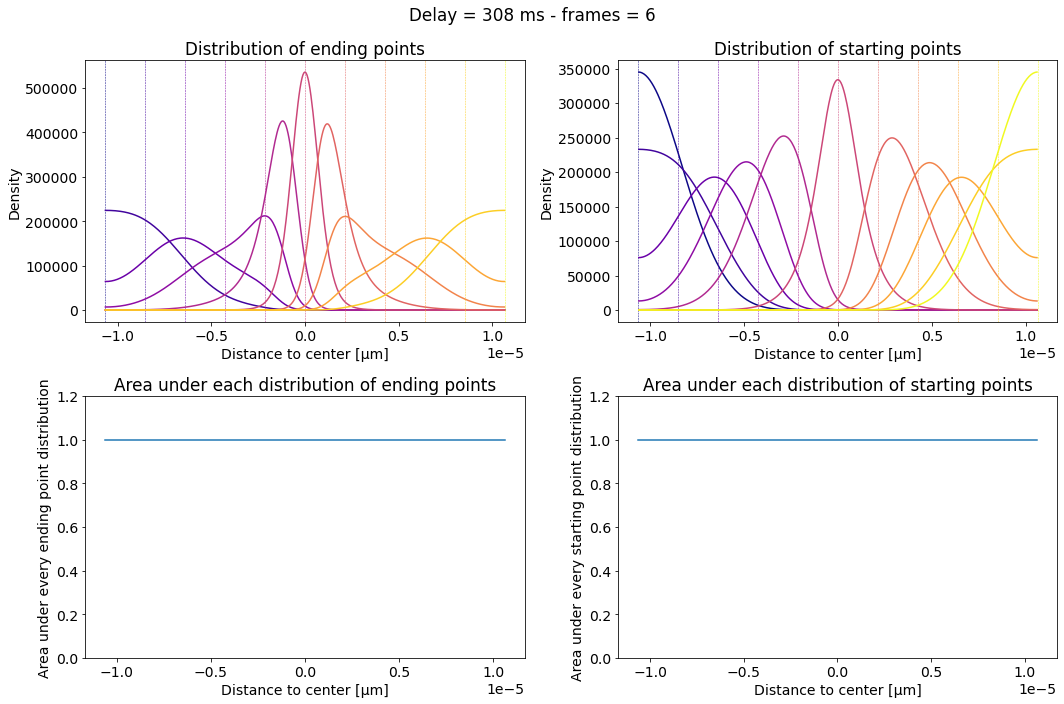

1.85 µm


In [5]:
colorwave = cm.plasma(np.linspace(0, 1, nx))
fig, ax = plt.subplots(figsize=(15,10)) 
fig.suptitle('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
ax1 = plt.subplot(2,2,1)
for i in range(nx):
    if i % int(nx/10) == 0:
        ax1.plot(x,endpointarray[:,i],color=colorwave[i])
        ax1.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Density') 
ax1.set_title('Distribution of ending points')
#ax1.set_xlim([-boundaryradius,boundaryradius])

ax2 = plt.subplot(2,2,2)
for i in range(nx):
    if i % int(nx/10) == 0:
        ax2.plot(x,startpointarray[:,i],color=colorwave[i])
        ax2.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Density') 
ax2.set_title('Distribution of starting points')

ax3 = plt.subplot(2,2,3)
ax3.plot(x,areaend)
ax3.set_ylim([0,1.2])
ax3.set_xlabel('Distance to center [µm]')
ax3.set_ylabel('Area under every ending point distribution') 
ax3.set_title('Area under each distribution of ending points')

ax4 = plt.subplot(2,2,4)
ax4.plot(x,areastart)
ax4.set_ylim([0,1.2])
ax4.set_xlabel('Distance to center [µm]')
ax4.set_ylabel('Area under every starting point distribution') 
ax4.set_title('Area under each distribution of starting points')

plt.tight_layout() 
plt.savefig('Density profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
plt.savefig('Density profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
plt.show()

print(str(round(vactive*totaltime*1e6,2))+' µm')

## Calculate new velocity profile by multiplying the original velocity profile with the starting point distributions

In [6]:
newvelocity = np.zeros(nx)
for k in range(nx): newvelocity[k] = np.sum(varray[1:-1] * startpointarray[1:-1,k])*delta_x

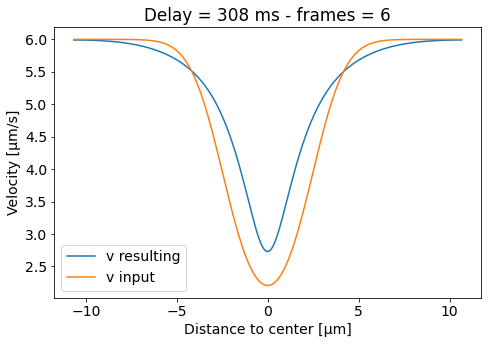

5.263733907346454e-06
5.038545264970903e-06


In [7]:
fig, ax = plt.subplots(figsize=(7,5)) 
plt.plot(x*1e6,newvelocity*1e6,label='v resulting')
plt.plot(xarray*1e6,varray*1e6,label='v input')
plt.title('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
plt.xlabel('Distance to center [µm]')
plt.ylabel('Velocity [µm/s]') 
plt.legend()
plt.tight_layout() 
plt.savefig('v profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
plt.savefig('v profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
plt.show()

print(np.mean(newvelocity))
print(np.mean(varray))

## Solve the FPE with the new D_eff

In [12]:
ntnew = 1000
dttotalnew = 50
delta_tnew = dttotalnew/ntnew

#Calculate D_eff
Darraynew = D_0 + newvelocity**2*tauR/4

#Calculate the matrix
G = delta_tnew/delta_x**2
M = np.zeros((nx,nx))
for i in range(1,nx):
    M[i,i] = 1+G*(3*Darraynew[i]-Darraynew[i-1])
    M[i,i-1] = -G*Darraynew[i-1] 
    M[i-1,i] = G*(Darraynew[i-1]-2*Darraynew[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

#Solve FPE
unew = np.zeros((nx,ntnew))        #array to save the density distributions
unew[:,0] = 1/newvelocity
unew[:,0] /= sum(unew[:,0])*delta_x
for i in range(1,ntnew):
    b = unew[:,i-1].copy()
    b[0] = 0
    b[-1] = 0#b[1]
    csingle = np.linalg.solve(M,b)
    unew[:,i] = csingle/sum(abs(csingle)*delta_x)

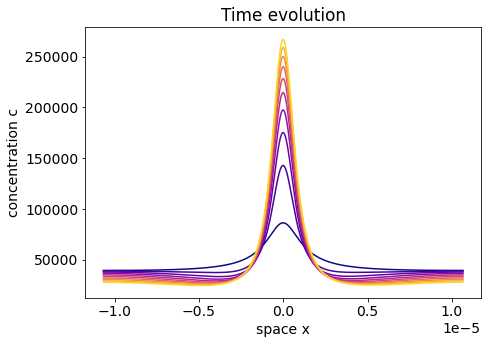

In [13]:
    c = unew
    colorwave = cm.plasma(np.linspace(0, 1, nt))
    fig=plt.figure(1, figsize = (7,5) )
    host = plt.subplot(1,1,1)
    for i in range(nt):
        if i % int(nt/10) == 0:
            plt.plot(x,c[:,i],c=colorwave[i])
            plt.xlabel('space x')
            plt.ylabel('concentration c')
            #plt.title(str(title))
    #plt.ylim([0,1.05*np.amax(c)])
    plt.title('Time evolution')
    plt.tight_layout()  
    #plt.savefig(str(title)+'.svg', format='svg')
    plt.show()

## Solve FPE without D_eff for comparison

In [18]:
#Calculate matrix
M = np.zeros((nx,nx))
for i in range(1,nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1

#Solve FPE
unew2 = np.zeros((nx,ntnew))        #array to save the density distributions
unew2[:,0] = 1/varray
unew2[:,0] /= sum(unew2[:,0])*delta_x
for i in range(1,ntnew):
    b = unew2[:,i-1].copy()
    b[0] = 0
    b[-1] = 0#b[1]
    csingle = np.linalg.solve(M,b)
    unew2[:,i] = csingle/sum(abs(csingle)*delta_x)

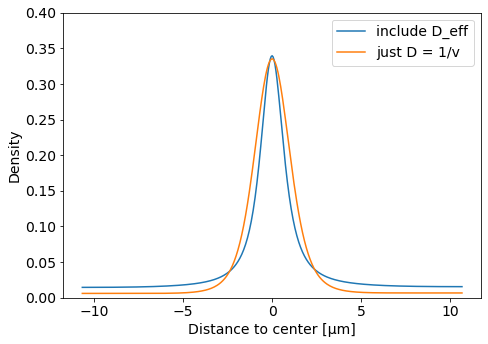

In [15]:
fig=plt.figure(1, figsize = (7,5) )
ax1 = plt.subplot(1,1,1)

plt.plot(x*1e6,c[:,-1]*1e-6,label='include D_eff')
#plt.plot(x,unew[:,0])
test = 1/varray
test /= sum(test)*delta_x
#plt.plot(x,test)

plt.plot(x*1e6,unew2[:,-1]*1e-6,label = 'just D = 1/v')

plt.ylim([0,0.4])

ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Density') 

plt.legend()
plt.tight_layout() 
plt.savefig('Density profiles compared - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
plt.savefig('Density profiles compared - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
plt.show()

In [17]:
print(sum(c[:,-1])*delta_x)
print(sum(unew2[:,-1])*delta_x)

1.0000000000000013
1.0000000000000016
